# RUDDER Credit Assignment Analysis

This notebook compares RUDDER's learned credit assignment with the ground truth DodgeWindowModel.

**RUDDER** learns to predict episode return from (state, action) sequences. Credit assignment comes from the difference in predictions:
- `credit[t] = pred[t] - pred[t-1]`
- Negative credit = "this is where things went wrong"
- With a random policy that mostly doesn't dodge, we expect **negative credit in dodge windows**

In [46]:
import sys
sys.path.insert(0, '..')

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

from dodge_policy.rudder_model import load_model, get_credit
from dodge_policy.visualize_rudder import get_credit_per_attack
from dodge_policy.dodge_window_model import DodgeWindowModel
from dodge_policy.ppo import anim_id_to_index, ANIM_VOCAB

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

## Load Models

In [47]:
# Load RUDDER model
model, params, config, stats = load_model('../rudder_model')
print(f"RUDDER model loaded")
print(f"  Hidden dim: {config.hidden_dim}")
print(f"  Mode: {stats.get('mode', 'full_episode')}")
if stats.get('mode') == 'per_attack':
    print(f"  Max sequence length: {stats.get('max_len', 64)}")
    print(f"  Target: binary (hit=1, no hit=0)")
else:
    print(f"  Target: total episode return")
print(f"  Return stats: mean={stats['return_mean']:.2f}, std={stats['return_std']:.2f}")

# Load ground truth
gt_model = DodgeWindowModel.load('../dodge_windows.json')
print(f"\nGround truth: {len(gt_model.windows)} animations with dodge windows")

RUDDER model loaded
  Hidden dim: 128
  Mode: per_attack
  Max sequence length: 64
  Target: binary (hit=1, no hit=0)
  Return stats: mean=-0.50, std=0.50
Loaded dodge window model: 20 animations, 22 windows (2 bimodal)

Ground truth: 20 animations with dodge windows


## Explore Ground Truth Windows

In [48]:
print("Ground Truth Dodge Windows:")
print("-" * 70)
for idx, windows in sorted(gt_model.windows.items()):
    for w in windows:
        print(f"  idx={idx:2d} | {w.anim_name:10s} | "
              f"mean={w.dodge_mean_frames:5.1f} | std={w.dodge_std_frames:4.1f} | "
              f"n_dodges={w.n_dodges:2d}")

Ground Truth Dodge Windows:
----------------------------------------------------------------------
  idx=10 | 2003000    | mean= 10.0 | std= 1.2 | n_dodges=37
  idx=11 | 2003001    | mean= 13.7 | std= 1.3 | n_dodges= 7
  idx=12 | 2003003    | mean=  5.5 | std= 0.5 | n_dodges= 2
  idx=14 | 2003005    | mean=  9.0 | std= 0.9 | n_dodges=13
  idx=15 | 2003006    | mean= 11.9 | std= 1.4 | n_dodges=35
  idx=16 | 2003007    | mean= 11.9 | std= 0.8 | n_dodges=17
  idx=17 | 2003008    | mean= 12.8 | std= 0.9 | n_dodges=33
  idx=18 | 2003009    | mean=  6.5 | std= 1.0 | n_dodges=13
  idx=18 | 2003009    | mean= 21.3 | std= 1.4 | n_dodges=13
  idx=19 | 2003011    | mean=  6.3 | std= 1.0 | n_dodges=38
  idx=20 | 2003012    | mean= 15.1 | std= 1.0 | n_dodges=19
  idx=21 | 2003014    | mean=  7.0 | std= 1.3 | n_dodges=19
  idx=22 | 2003015    | mean= 15.3 | std= 0.5 | n_dodges= 3
  idx=23 | 2003016    | mean=  7.2 | std= 0.7 | n_dodges= 6
  idx=24 | 2003017    | mean=  6.9 | std= 0.8 | n_dodges=28
 

## Explore Collected Data

In [49]:
data_dir = Path('../rudder_data')
episode_files = sorted(data_dir.glob('episode_*.npz'))
print(f"Episodes: {len(episode_files)}")

# Count animations
anim_counter = Counter()
total_frames = 0
for f in episode_files:
    data = np.load(f)
    total_frames += len(data['actions'])
    for anim_id in data['boss_anim_id']:
        idx = anim_id_to_index(int(anim_id))
        anim_counter[(int(anim_id), idx)] += 1

print(f"Total frames: {total_frames:,}")
print(f"\nTop 10 animations in data:")
for (anim_id, idx), count in anim_counter.most_common(10):
    has_gt = "✓" if idx in gt_model.windows else " "
    print(f"  {has_gt} {anim_id} (idx={idx:2d}): {count:5d} frames ({100*count/total_frames:.1f}%)")

Episodes: 50
Total frames: 51,200

Top 10 animations in data:
  ✓ 2003021 (idx=27):  5864 frames (11.5%)
  ✓ 2003009 (idx=18):  3663 frames (7.2%)
  ✓ 2003015 (idx=22):  3519 frames (6.9%)
  ✓ 2003025 (idx=30):  3238 frames (6.3%)
  ✓ 2003006 (idx=15):  3137 frames (6.1%)
  ✓ 2003000 (idx=10):  2937 frames (5.7%)
    2006003 (idx=39):  2490 frames (4.9%)
  ✓ 2003014 (idx=21):  2456 frames (4.8%)
  ✓ 2003039 (idx=34):  2220 frames (4.3%)
    2006002 (idx=38):  2198 frames (4.3%)


## Compute Credit Assignment for All Episodes

In [50]:
# Collect credits by (anim_idx, elapsed_frame)
anim_credits = {}  # anim_idx -> {elapsed: [credits]}

# Check model mode
mode = stats.get('mode', 'full_episode')
max_len = stats.get('max_len', 64)
print(f"Model mode: {mode}")

for ep_file in episode_files:
    data = np.load(ep_file)
    T = len(data['actions'])

    if mode == 'per_attack':
        # Use per-attack credit computation (matches training)
        credit, _ = get_credit_per_attack(model, params, dict(data), stats, max_len)
        credit = credit * stats['return_std']  # Denormalize
    else:
        # Full episode mode
        boss_anim = jnp.array(data['boss_anim_id'], dtype=jnp.int32)
        hero_anim = jnp.array(data['hero_anim_id'], dtype=jnp.int32)

        dist = (data['dist_to_boss'] - stats['dist_mean']) / stats['dist_std']
        hp = (data['hero_hp'] - stats['hp_mean']) / stats['hp_std']
        action = data['actions'].astype(np.float32)

        if 'elapsed_mean' in stats:
            elapsed = (data['elapsed_frames'] - stats['elapsed_mean']) / stats['elapsed_std']
            continuous = np.stack([elapsed, dist, hp, action], axis=-1).astype(np.float32)
        else:
            continuous = np.stack([dist, hp, action], axis=-1).astype(np.float32)

        credit = np.array(get_credit(model, params, boss_anim, hero_anim, jnp.array(continuous)))
        credit = credit * stats['return_std']  # Denormalize

    for t in range(T):
        raw_anim_id = int(data['boss_anim_id'][t])
        anim_idx = anim_id_to_index(raw_anim_id)
        elapsed = int(data['elapsed_frames'][t])

        if anim_idx not in anim_credits:
            anim_credits[anim_idx] = {}
        if elapsed not in anim_credits[anim_idx]:
            anim_credits[anim_idx][elapsed] = []
        anim_credits[anim_idx][elapsed].append(credit[t])

print(f"Processed {len(anim_credits)} unique animation indices")

Model mode: per_attack
Processed 34 unique animation indices


## Compare Single Animation: RUDDER vs Ground Truth

In [51]:
# Colorblind-friendly palette
COLOR_POSITIVE = '#0072B2'  # Blue - positive credit
COLOR_NEGATIVE = '#D55E00'  # Orange - negative credit  
COLOR_GT_WINDOW = '#CC79A7'  # Pink/magenta - ground truth window
COLOR_GT_LINE = '#882255'    # Dark magenta - ground truth center

def plot_animation_credit(anim_idx, anim_credits, gt_model, figsize=(12, 5)):
    """Plot RUDDER credit vs ground truth for a single animation."""
    if anim_idx not in anim_credits:
        print(f"No data for animation idx={anim_idx}")
        return
    
    elapsed_credits = anim_credits[anim_idx]
    frames = sorted(elapsed_credits.keys())
    max_frame = max(frames)

    # Compute mean credit at each frame
    mean_credits = []
    for f in range(max_frame + 1):
        if f in elapsed_credits:
            mean_credits.append(np.mean(elapsed_credits[f]))
        else:
            mean_credits.append(0)
    
    mean_credits = np.array(mean_credits)
    
    # Normalize by max absolute value
    max_abs = np.abs(mean_credits).max()
    if max_abs > 0:
        mean_credits_norm = mean_credits / max_abs
    else:
        mean_credits_norm = mean_credits

    fig, ax = plt.subplots(figsize=figsize)

    # Bar chart of credits (blue=positive, orange=negative)
    colors = [COLOR_POSITIVE if c > 0 else COLOR_NEGATIVE for c in mean_credits_norm]
    ax.bar(range(max_frame + 1), mean_credits_norm, color=colors, alpha=0.7, width=1.0)
    ax.axhline(0, color='black', linewidth=0.5)

    # Ground truth window (pink/magenta)
    windows = gt_model.windows.get(anim_idx, [])
    anim_name = windows[0].anim_name if windows else f"idx_{anim_idx}"
    
    for i, w in enumerate(windows):
        mean_f = w.dodge_mean_frames
        std_f = w.dodge_std_frames
        label = 'GT Window' if i == 0 else None
        ax.axvspan(mean_f - 2*std_f, mean_f + 2*std_f, alpha=0.3, color=COLOR_GT_WINDOW, label=label)
        ax.axvline(mean_f, color=COLOR_GT_LINE, linestyle='--', linewidth=2)

    ax.set_xlabel('Elapsed Frames', fontsize=12)
    ax.set_ylabel('Normalized Credit', fontsize=12)
    ax.set_ylim(-1.1, 1.1)
    ax.set_title(f'Animation {anim_name} (idx={anim_idx})\n'
                 f'ORANGE = negative credit (missed dodge), PINK = ground truth window', fontsize=12)
    if windows:
        ax.legend()

    plt.tight_layout()
    
    # Compute stats (using original non-normalized values)
    in_window = []
    out_window = []
    for f, credits in elapsed_credits.items():
        in_any = any(abs(f - w.dodge_mean_frames) <= 2 * w.dodge_std_frames for w in windows)
        if in_any:
            in_window.extend(credits)
        else:
            out_window.extend(credits)
    
    if in_window and out_window:
        print(f"Animation {anim_name} (idx={anim_idx}):")
        print(f"  Avg credit IN window:  {np.mean(in_window):.4f}")
        print(f"  Avg credit OUT window: {np.mean(out_window):.4f}")
        diff = np.mean(in_window) - np.mean(out_window)
        status = "✓ CORRECT" if diff < 0 else "✗ WRONG"
        print(f"  Difference: {diff:.4f} ({status})")
    
    return fig

Animation 2003000 (idx=10):
  Avg credit IN window:  -0.1079
  Avg credit OUT window: 0.0441
  Difference: -0.1520 (✓ CORRECT)


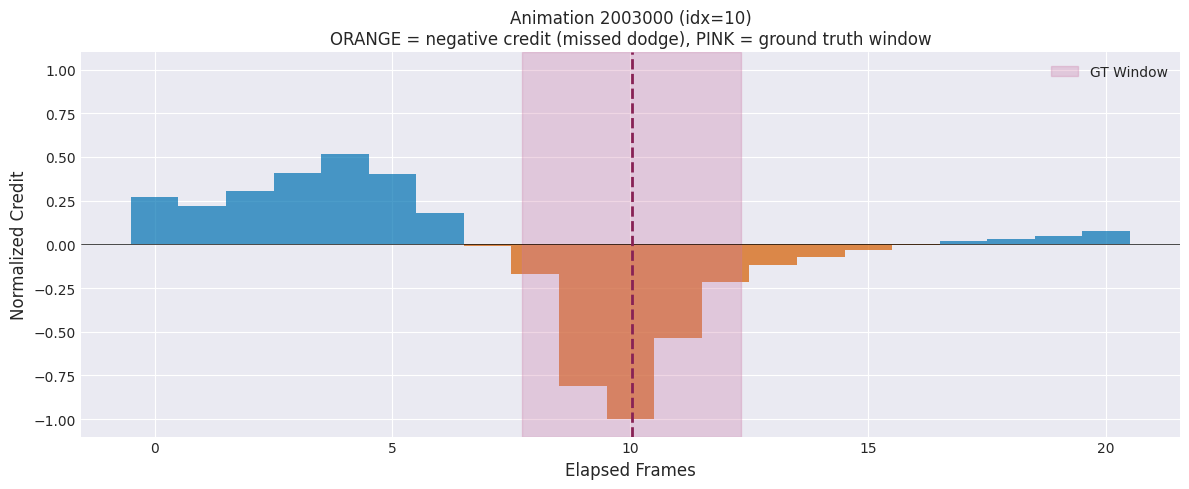

In [52]:
# Animation 2003000 (idx=10) - most ground truth dodges
plot_animation_credit(10, anim_credits, gt_model);

Animation 2003011 (idx=19):
  Avg credit IN window:  -0.0707
  Avg credit OUT window: 0.0413
  Difference: -0.1119 (✓ CORRECT)


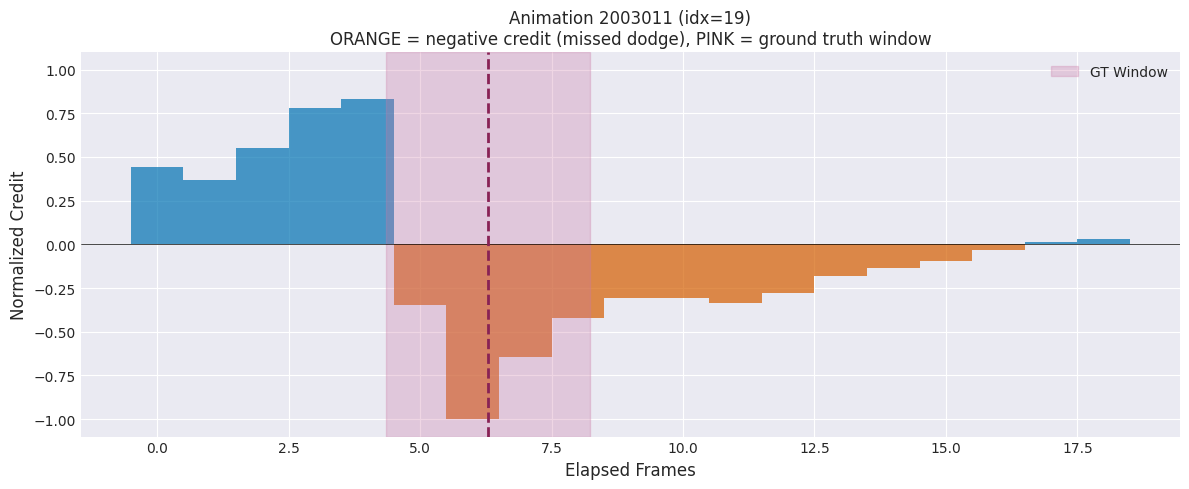

In [53]:
# Animation 2003011 (idx=19) - second most ground truth dodges  
plot_animation_credit(19, anim_credits, gt_model);

Animation 2003006 (idx=15):
  Avg credit IN window:  -0.1046
  Avg credit OUT window: 0.0358
  Difference: -0.1405 (✓ CORRECT)


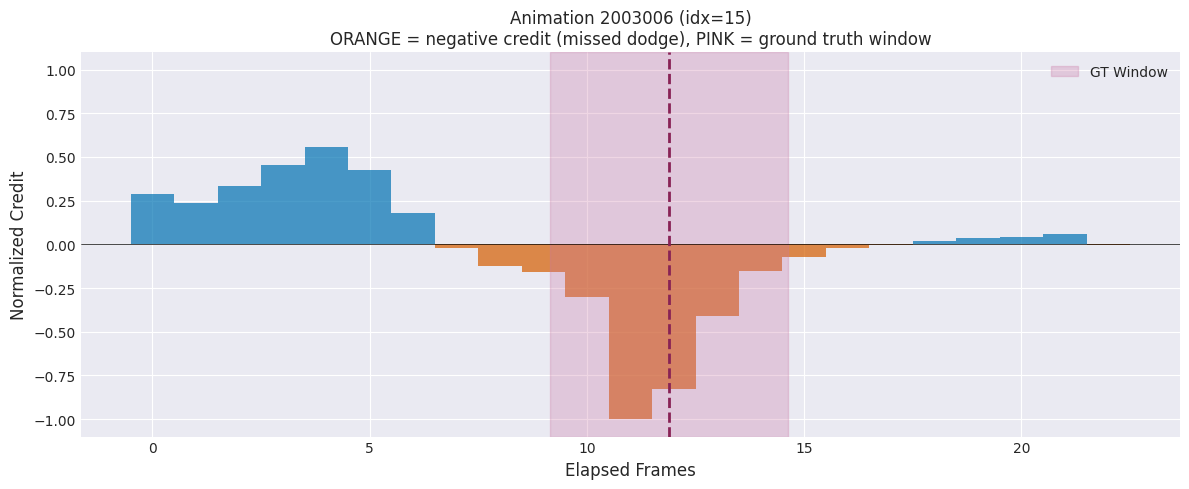

In [54]:
# Animation 2003006 (idx=15)
plot_animation_credit(15, anim_credits, gt_model);

## Compare All Animations with Ground Truth

Animations with both GT and data: 19


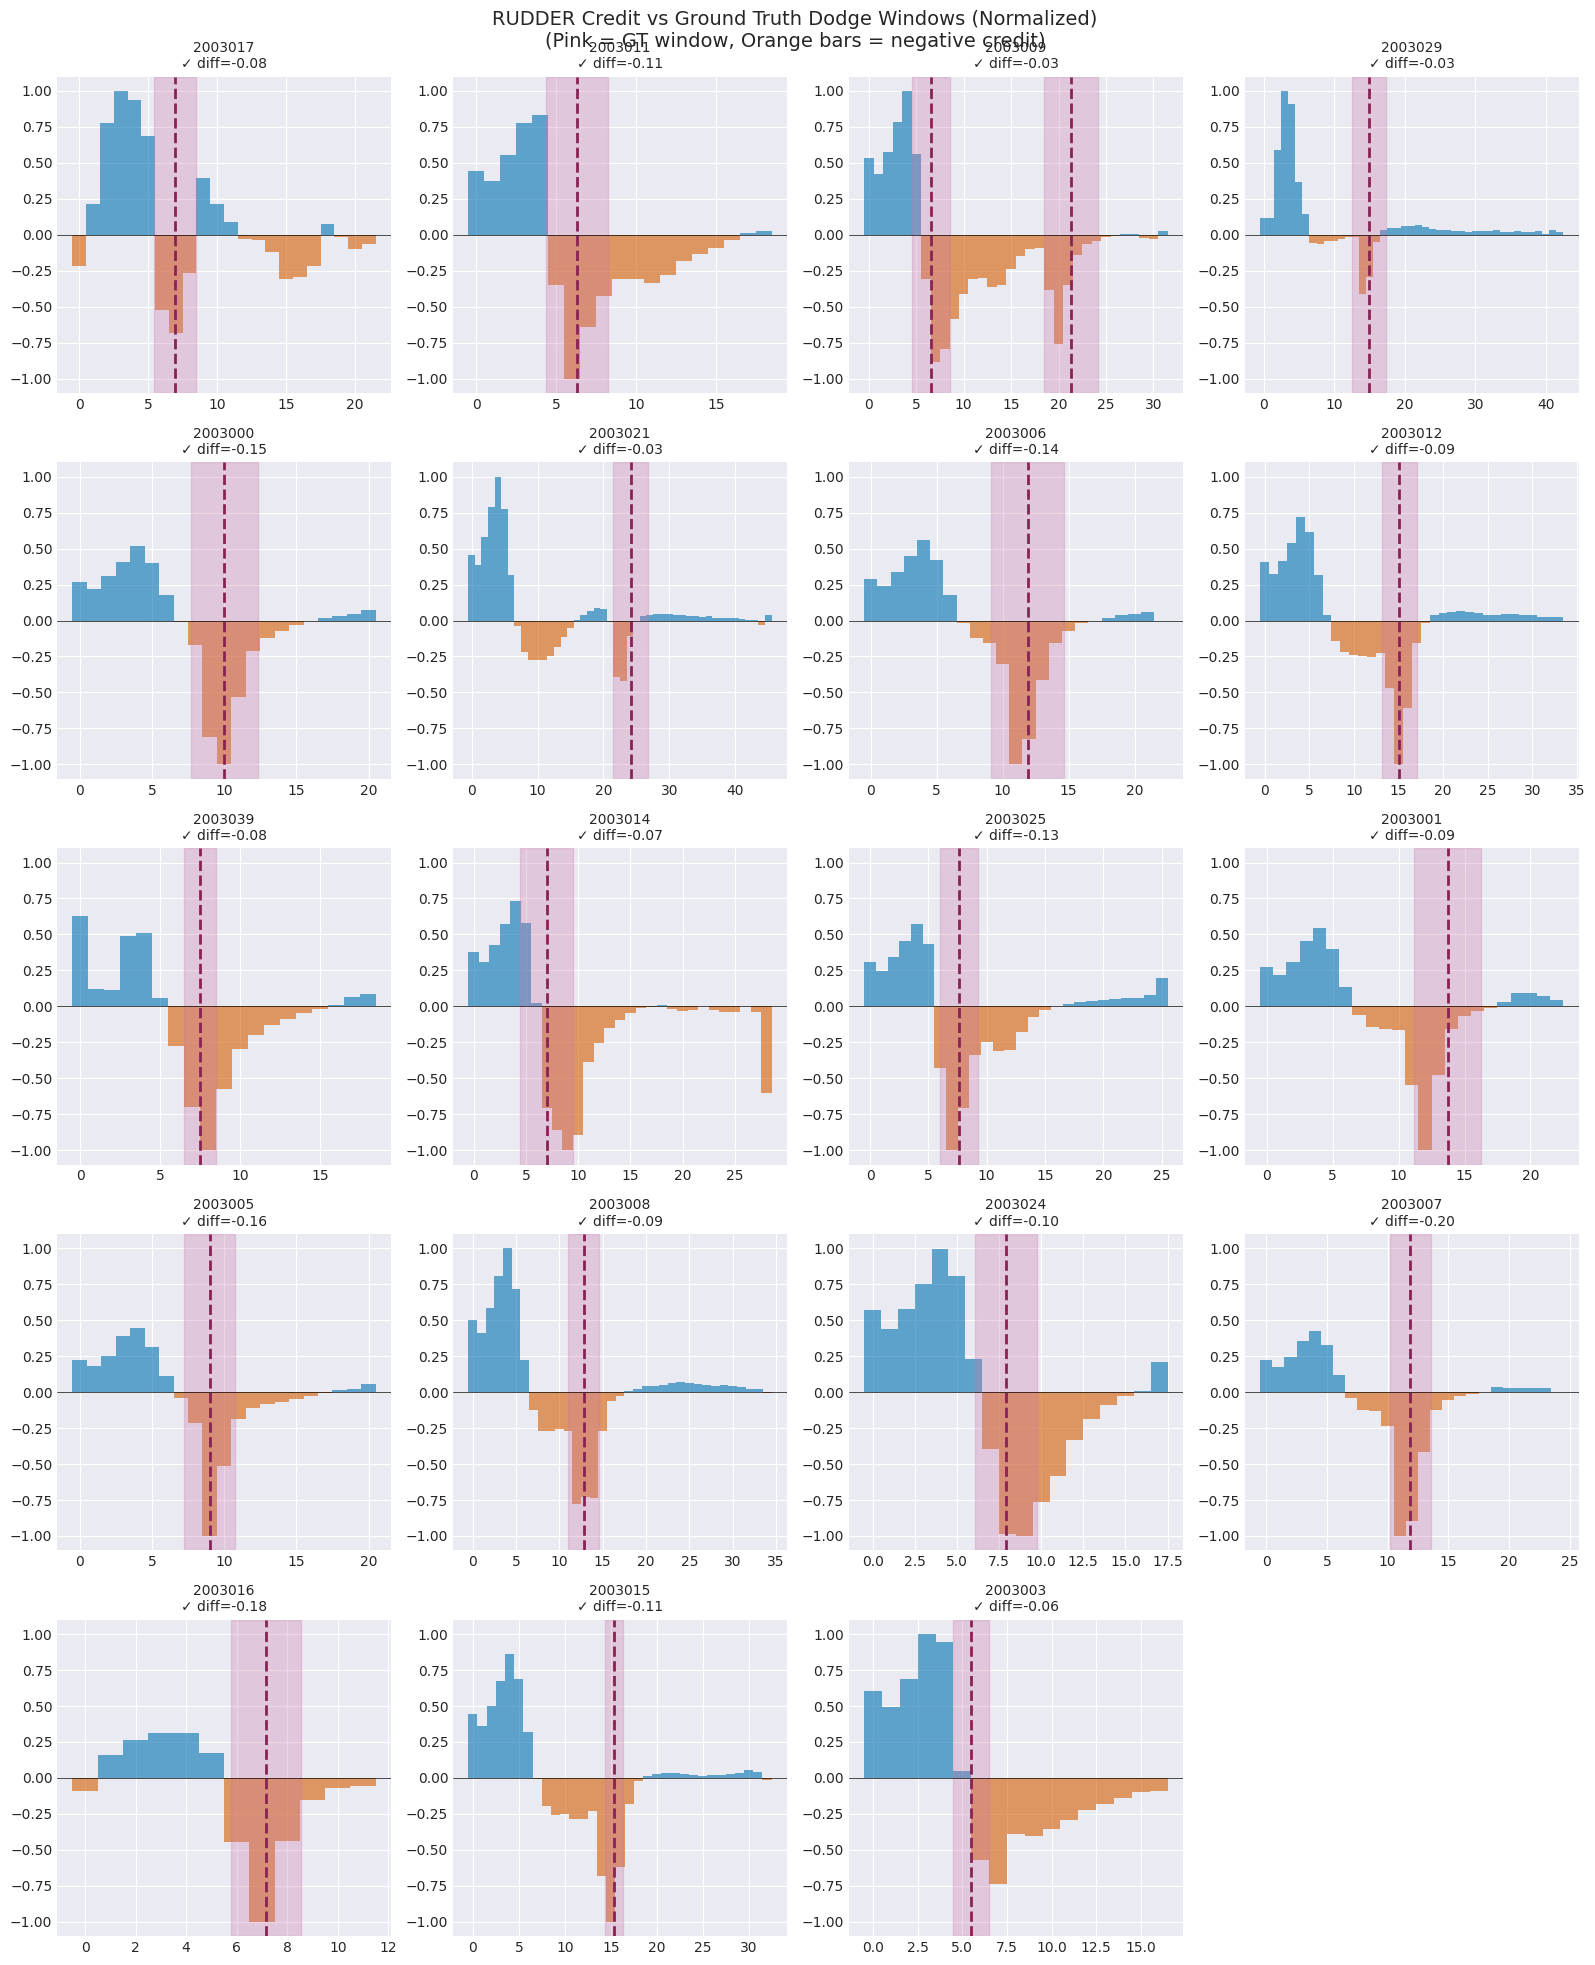

In [55]:
# Find animations that have both ground truth and collected data
anims_with_both = [idx for idx in gt_model.windows.keys() if idx in anim_credits]
n_anims = len(anims_with_both)
print(f"Animations with both GT and data: {n_anims}")

cols = 4
rows = (n_anims + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
axes = np.array(axes).flatten()

results = []

for i, anim_idx in enumerate(anims_with_both):
    ax = axes[i]
    elapsed_credits = anim_credits[anim_idx]
    frames = sorted(elapsed_credits.keys())
    max_frame = max(frames) if frames else 100

    mean_credits = np.array([np.mean(elapsed_credits.get(f, [0])) for f in range(max_frame + 1)])
    
    # Normalize by max absolute value
    max_abs = np.abs(mean_credits).max()
    if max_abs > 0:
        mean_credits_norm = mean_credits / max_abs
    else:
        mean_credits_norm = mean_credits

    # Colorblind-friendly: blue=positive, orange=negative
    colors = [COLOR_POSITIVE if c > 0 else COLOR_NEGATIVE for c in mean_credits_norm]
    ax.bar(range(max_frame + 1), mean_credits_norm, color=colors, alpha=0.6, width=1.0)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_ylim(-1.1, 1.1)

    # Ground truth windows in pink/magenta
    windows = gt_model.windows.get(anim_idx, [])
    for w in windows:
        ax.axvspan(w.dodge_mean_frames - 2*w.dodge_std_frames, 
                   w.dodge_mean_frames + 2*w.dodge_std_frames, 
                   alpha=0.3, color=COLOR_GT_WINDOW)
        ax.axvline(w.dodge_mean_frames, color=COLOR_GT_LINE, linestyle='--', linewidth=2)

    anim_name = windows[0].anim_name if windows else f"idx_{anim_idx}"
    
    # Stats (using original non-normalized values)
    in_window = []
    out_window = []
    for f, credits in elapsed_credits.items():
        in_any = any(abs(f - w.dodge_mean_frames) <= 2 * w.dodge_std_frames for w in windows)
        if in_any:
            in_window.extend(credits)
        else:
            out_window.extend(credits)
    
    if in_window and out_window:
        diff = np.mean(in_window) - np.mean(out_window)
        status = "✓" if diff < 0 else "✗"
        results.append((anim_idx, anim_name, np.mean(in_window), np.mean(out_window), diff, status))
        ax.set_title(f"{anim_name}\n{status} diff={diff:.2f}", fontsize=10)
    else:
        ax.set_title(f"{anim_name}", fontsize=10)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle("RUDDER Credit vs Ground Truth Dodge Windows (Normalized)\n"
             "(Pink = GT window, Orange bars = negative credit)", fontsize=14)
plt.tight_layout()
plt.savefig('rudder_all_anims.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary Table

In [56]:
import pandas as pd

df = pd.DataFrame(results, columns=['idx', 'name', 'in_window', 'out_window', 'diff', 'status'])
df = df.sort_values('diff')

print("RUDDER vs Ground Truth Summary")
print("="*60)
print(df.to_string(index=False))
print("="*60)
correct = (df['status'] == '✓').sum()
print(f"\nCorrect: {correct}/{len(df)} ({100*correct/len(df):.0f}%)")
print(f"Overall avg IN window:  {df['in_window'].mean():.4f}")
print(f"Overall avg OUT window: {df['out_window'].mean():.4f}")

RUDDER vs Ground Truth Summary
 idx    name  in_window  out_window      diff status
  16 2003007  -0.185092    0.018892 -0.203984      ✓
  23 2003016  -0.157096    0.026455 -0.183551      ✓
  14 2003005  -0.132152    0.026070 -0.158222      ✓
  10 2003000  -0.107950    0.044099 -0.152049      ✓
  15 2003006  -0.104619    0.035848 -0.140467      ✓
  30 2003025  -0.119961    0.009358 -0.129319      ✓
  19 2003011  -0.070654    0.041255 -0.111909      ✓
  22 2003015  -0.098113    0.009051 -0.107164      ✓
  29 2003024  -0.077000    0.018969 -0.095968      ✓
  17 2003008  -0.080564    0.013382 -0.093946      ✓
  20 2003012  -0.077609    0.014908 -0.092517      ✓
  11 2003001  -0.067653    0.018772 -0.086424      ✓
  24 2003017  -0.049556    0.031396 -0.080951      ✓
  34 2003039  -0.073384    0.001805 -0.075189      ✓
  21 2003014  -0.055511    0.014630 -0.070141      ✓
  12 2003003  -0.021101    0.040941 -0.062042      ✓
  18 2003009  -0.032614    0.002204 -0.034819      ✓
  32 2003029  -

## Interpretation

**If RUDDER learned correctly:**
- Credit should be **more negative** inside dodge windows
- This is because the random policy usually doesn't dodge → gets hit → negative return
- RUDDER learns that "not dodging in the window" causes the bad outcome

**Reading the plots (colorblind-friendly):**
- **Orange bars** = negative credit = "this is where mistakes happen"
- **Blue bars** = positive credit = "this helped"
- **Pink shaded region** = ground truth dodge window
- **Ideal**: Orange bars concentrated inside pink regions

## Plot Random Episode

Episode: episode_0040.npz


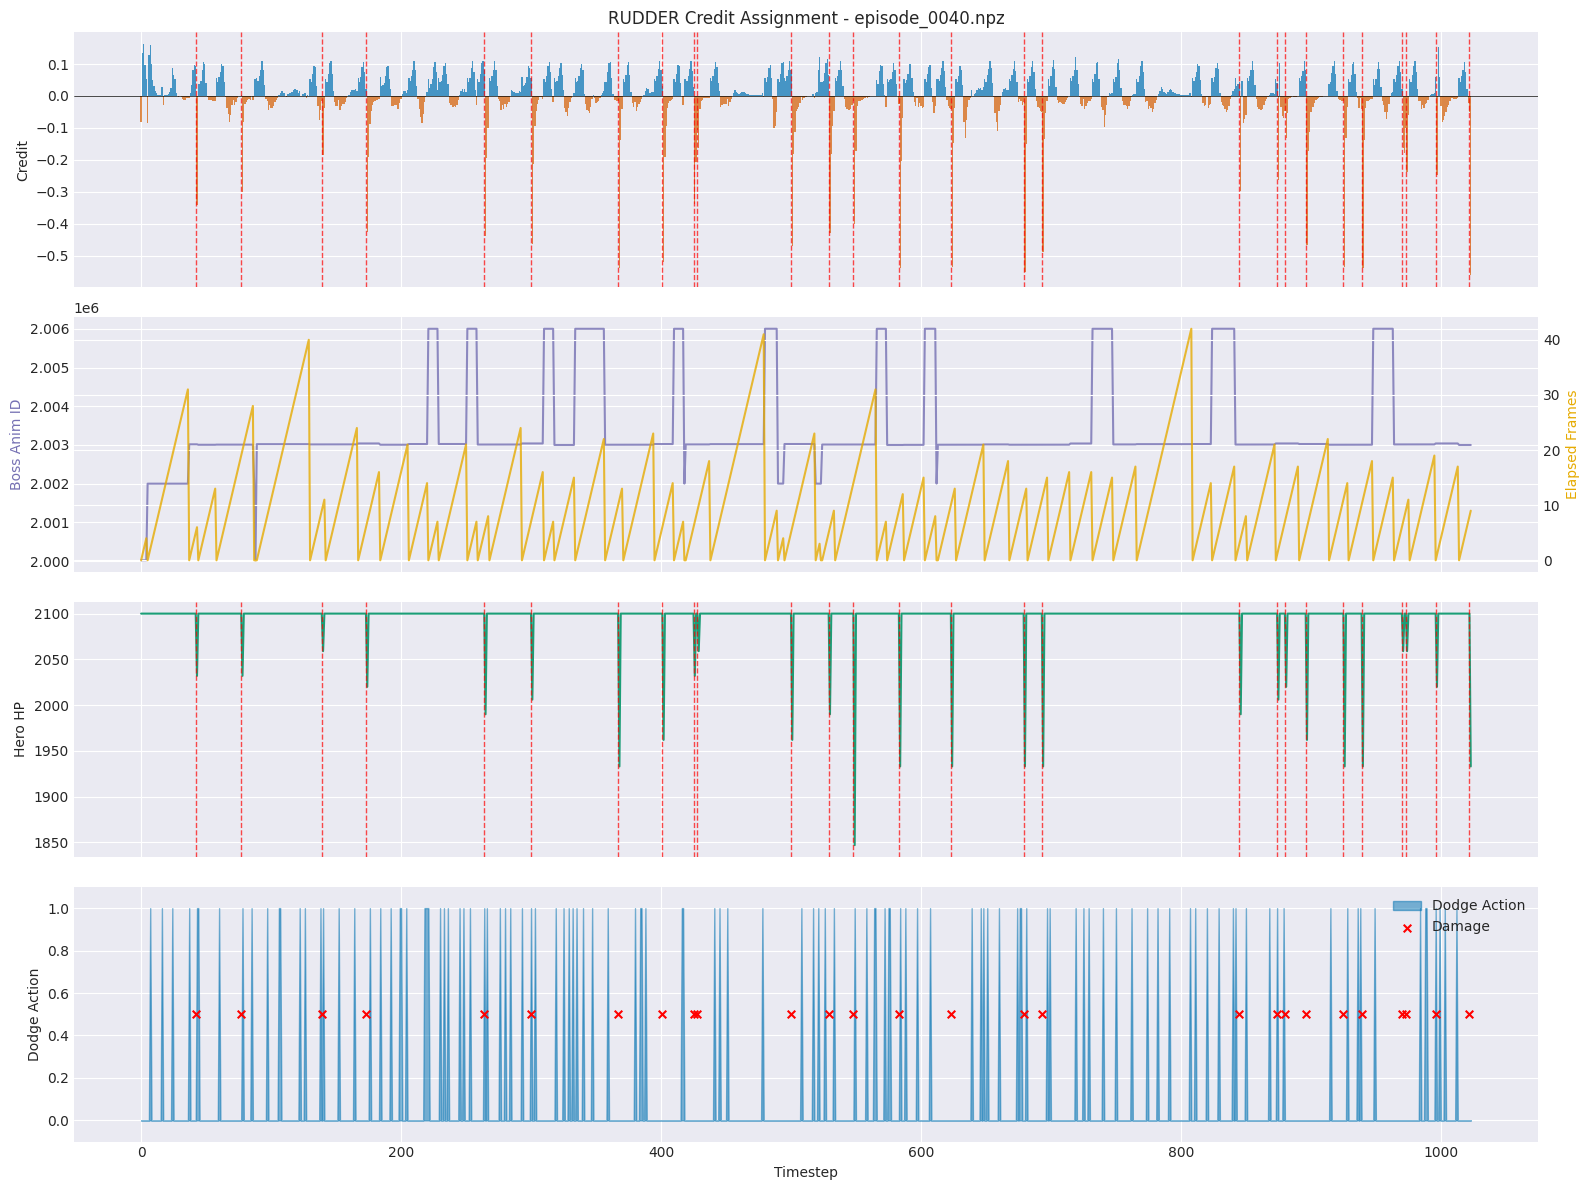


Episode stats:
  Total frames: 1024
  Damage events: 27
  Total damage: 3129
  Dodges: 118


In [57]:
# Pick a random episode and plot credit assignment over time
import random
random.seed(42)
ep_file = random.choice(episode_files)
print(f"Episode: {ep_file.name}")

data = np.load(ep_file)
T = len(data['actions'])

# Compute credit using appropriate mode
if mode == 'per_attack':
    credit, _ = get_credit_per_attack(model, params, dict(data), stats, max_len)
    credit = credit * stats['return_std']
else:
    boss_anim = jnp.array(data['boss_anim_id'], dtype=jnp.int32)
    hero_anim = jnp.array(data['hero_anim_id'], dtype=jnp.int32)

    dist = (data['dist_to_boss'] - stats['dist_mean']) / stats['dist_std']
    hp = (data['hero_hp'] - stats['hp_mean']) / stats['hp_std']
    action = data['actions'].astype(np.float32)

    if 'elapsed_mean' in stats:
        elapsed = (data['elapsed_frames'] - stats['elapsed_mean']) / stats['elapsed_std']
        continuous = np.stack([elapsed, dist, hp, action], axis=-1).astype(np.float32)
    else:
        continuous = np.stack([dist, hp, action], axis=-1).astype(np.float32)

    credit = np.array(get_credit(model, params, boss_anim, hero_anim, jnp.array(continuous)))
    credit = credit * stats['return_std']

# Plot
fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)

# 1. Credit assignment
ax = axes[0]
colors = [COLOR_POSITIVE if c > 0 else COLOR_NEGATIVE for c in credit]
ax.bar(range(T), credit, color=colors, alpha=0.7, width=1.0)
ax.axhline(0, color='black', linewidth=0.5)
ax.set_ylabel('Credit')
ax.set_title(f'RUDDER Credit Assignment - {ep_file.name}')

# Mark damage events
damage_idx = np.where(data['damage_taken'] > 0)[0]
for idx in damage_idx:
    ax.axvline(idx, color='red', linestyle='--', alpha=0.7, linewidth=1)

# 2. Boss animation + elapsed frames
ax = axes[1]
ax.plot(data['boss_anim_id'], color='#7570B3', alpha=0.8, label='Boss Anim ID')
ax.set_ylabel('Boss Anim ID', color='#7570B3')
ax2 = ax.twinx()
ax2.plot(data['elapsed_frames'], color='#E6AB02', alpha=0.8, label='Elapsed Frames')
ax2.set_ylabel('Elapsed Frames', color='#E6AB02')

# 3. Player HP
ax = axes[2]
ax.plot(data['hero_hp'], color='#1B9E77', linewidth=1.5)
ax.set_ylabel('Hero HP')
for idx in damage_idx:
    ax.axvline(idx, color='red', linestyle='--', alpha=0.7, linewidth=1)

# 4. Actions (dodge)
ax = axes[3]
ax.fill_between(range(T), 0, data['actions'], alpha=0.5, color=COLOR_POSITIVE, label='Dodge Action')
ax.scatter(damage_idx, np.ones(len(damage_idx)) * 0.5, c='red', s=30, marker='x', label='Damage', zorder=5)
ax.set_ylabel('Dodge Action')
ax.set_xlabel('Timestep')
ax.set_ylim(-0.1, 1.1)
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

print(f"\nEpisode stats:")
print(f"  Total frames: {T}")
print(f"  Damage events: {len(damage_idx)}")
print(f"  Total damage: {data['damage_taken'].sum():.0f}")
print(f"  Dodges: {data['actions'].sum():.0f}")